In [67]:
# Interactive session
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

# Standard libraries
from itertools import compress, combinations, repeat

# Data
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from missingno import matrix, heatmap

# Machine learning
from sklearn.base import clone
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    LabelEncoder,
    OrdinalEncoder,
    StandardScaler,
    FunctionTransformer,
)
from sklearn.feature_selection import (
    SelectKBest,
    RFE,
    mutual_info_classif,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import balanced_accuracy_score, f1_score
from feature_engine.selection import DropFeatures
import feature_engine.encoding as fe
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.metrics import classification_report_imbalanced

# XGBoost
import xgboost as xgb

# Custom modules and other
import transformers as tfr
import joblib

## Global Settings

In [68]:
seed = np.random.seed(12)
rs = np.random.RandomState(seed)

## Data

In [69]:
df = pd.read_csv("../data/raw/diabetic_data.csv")
df.shape

(101766, 50)

In [70]:
# Memory usage in MB
(df.memory_usage(deep=True).sum() / 1024**2).round(2)

225.23

### Features

<center>  <img  src='../data/raw/table_of_features.png' width="700" />  </center>

In [71]:
df.dtypes[:25]

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
dtype: object

In [72]:
df.dtypes[25:]

repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide               object
glipizide                   object
glyburide                   object
tolbutamide                 object
pioglitazone                object
rosiglitazone               object
acarbose                    object
miglitol                    object
troglitazone                object
tolazamide                  object
examide                     object
citoglipton                 object
insulin                     object
glyburide-metformin         object
glipizide-metformin         object
glimepiride-pioglitazone    object
metformin-rosiglitazone     object
metformin-pioglitazone      object
change                      object
diabetesMed                 object
readmitted                  object
dtype: object

In [73]:
# Categorical features
cat_col = [
    "race",
    "gender",
    "age",
    "admission_type_id",
    "discharge_disposition_id",
    "admission_source_id",
    "payer_code",
    "medical_specialty",
    "diag_1",
    "diag_2",
    "diag_3",
    "max_glu_serum",
    "A1Cresult",
    "metformin",
    "repaglinide",
    "nateglinide",
    "chlorpropamide",
    "glimepiride",
    "acetohexamide",
    "glipizide",
    "glyburide",
    "tolbutamide",
    "pioglitazone",
    "rosiglitazone",
    "acarbose",
    "miglitol",
    "troglitazone",
    "tolazamide",
    "examide",
    "citoglipton",
    "insulin",
    "glyburide-metformin",
    "glipizide-metformin",
    "glimepiride-pioglitazone",
    "metformin-rosiglitazone",
    "metformin-pioglitazone",
    "change",
    "diabetesMed",
]

# Numerical features
num_col = [
    "weight",
    "time_in_hospital",
    "num_lab_procedures",
    "num_procedures",
    "num_medications",
    "number_outpatient",
    "number_emergency",
    "number_inpatient",
    "number_diagnoses",
]

# ID columns
ids = ["encounter_id", "patient_nbr"]

# Target column
target = "readmitted"

In [74]:
len(cat_col + num_col + ids + [target]) == df.shape[1]

True

## Target 

Check class distributions and skewness:

In [75]:
df[target].value_counts(dropna=False)

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

Imbalanced degrees:

In [76]:
df[target].value_counts(dropna=False, normalize=True)

NO     0.539119
>30    0.349282
<30    0.111599
Name: readmitted, dtype: float64

In [77]:
print(
    "Combinations of class ratios:",
    list(combinations(df[target].value_counts(dropna=False).index, 2)),
)
print(
    "Pairwise counts:",
    list(combinations(df[target].value_counts(dropna=False).tolist(), 2)),
)
print(
    "Ratios:",
    [
        round(x[0] / x[1], 2)
        for x in list(combinations(df[target].value_counts(dropna=False).tolist(), 2))
    ],
)

Combinations of class ratios: [('NO', '>30'), ('NO', '<30'), ('>30', '<30')]
Pairwise counts: [(54864, 35545), (54864, 11357), (35545, 11357)]
Ratios: [1.54, 4.83, 3.13]


There is quite some imbalance in our data set. Depending on noise level (in both minority and majority classes) and separability, it may be hard for the learning algorithm to learn the data. We need to involve some resampling techniques to help the learning algorithms. 

### ID Columns

In [78]:
for col in ids:
    print(f"Number of unique {col} is", df[col].nunique())

Number of unique encounter_id is 101766
Number of unique patient_nbr is 71518


In [79]:
for col in ids:
    print(f"Max length for {col} is", len(str(df[col].max())))

Max length for encounter_id is 9
Max length for patient_nbr is 9


If this 9-digit length is to be expected for future data, we can downcast from `int64` to `int32` in our pipeline.

### Numerical Features

In [80]:
df[num_col].select_dtypes(include="int64").apply(lambda x: len(str(x.max())))

time_in_hospital      2
num_lab_procedures    3
num_procedures        1
num_medications       2
number_outpatient     2
number_emergency      2
number_inpatient      2
number_diagnoses      2
dtype: int64

We can downsize from `int64` to `int16`, which can store integers between -32767 to 32767.

In [15]:
df.loc[df["weight"].notna(), "weight"].value_counts()

?            98569
[75-100)      1336
[50-75)        897
[100-125)      625
[125-150)      145
[25-50)         97
[0-25)          48
[150-175)       35
[175-200)       11
>200             3
Name: weight, dtype: int64

In [16]:
df.loc[df["weight"] == "?"].__len__() / df.shape[0]

0.9685847925633315

The weight column, a presumably extremely useful feature, contains a lot of missing values. We may have to drop this feature in the pipeline. Next, correlation heatmap.

In [17]:
df[num_col].replace("?", np.nan).corr().style.background_gradient(cmap="coolwarm")

Distribution of continous features

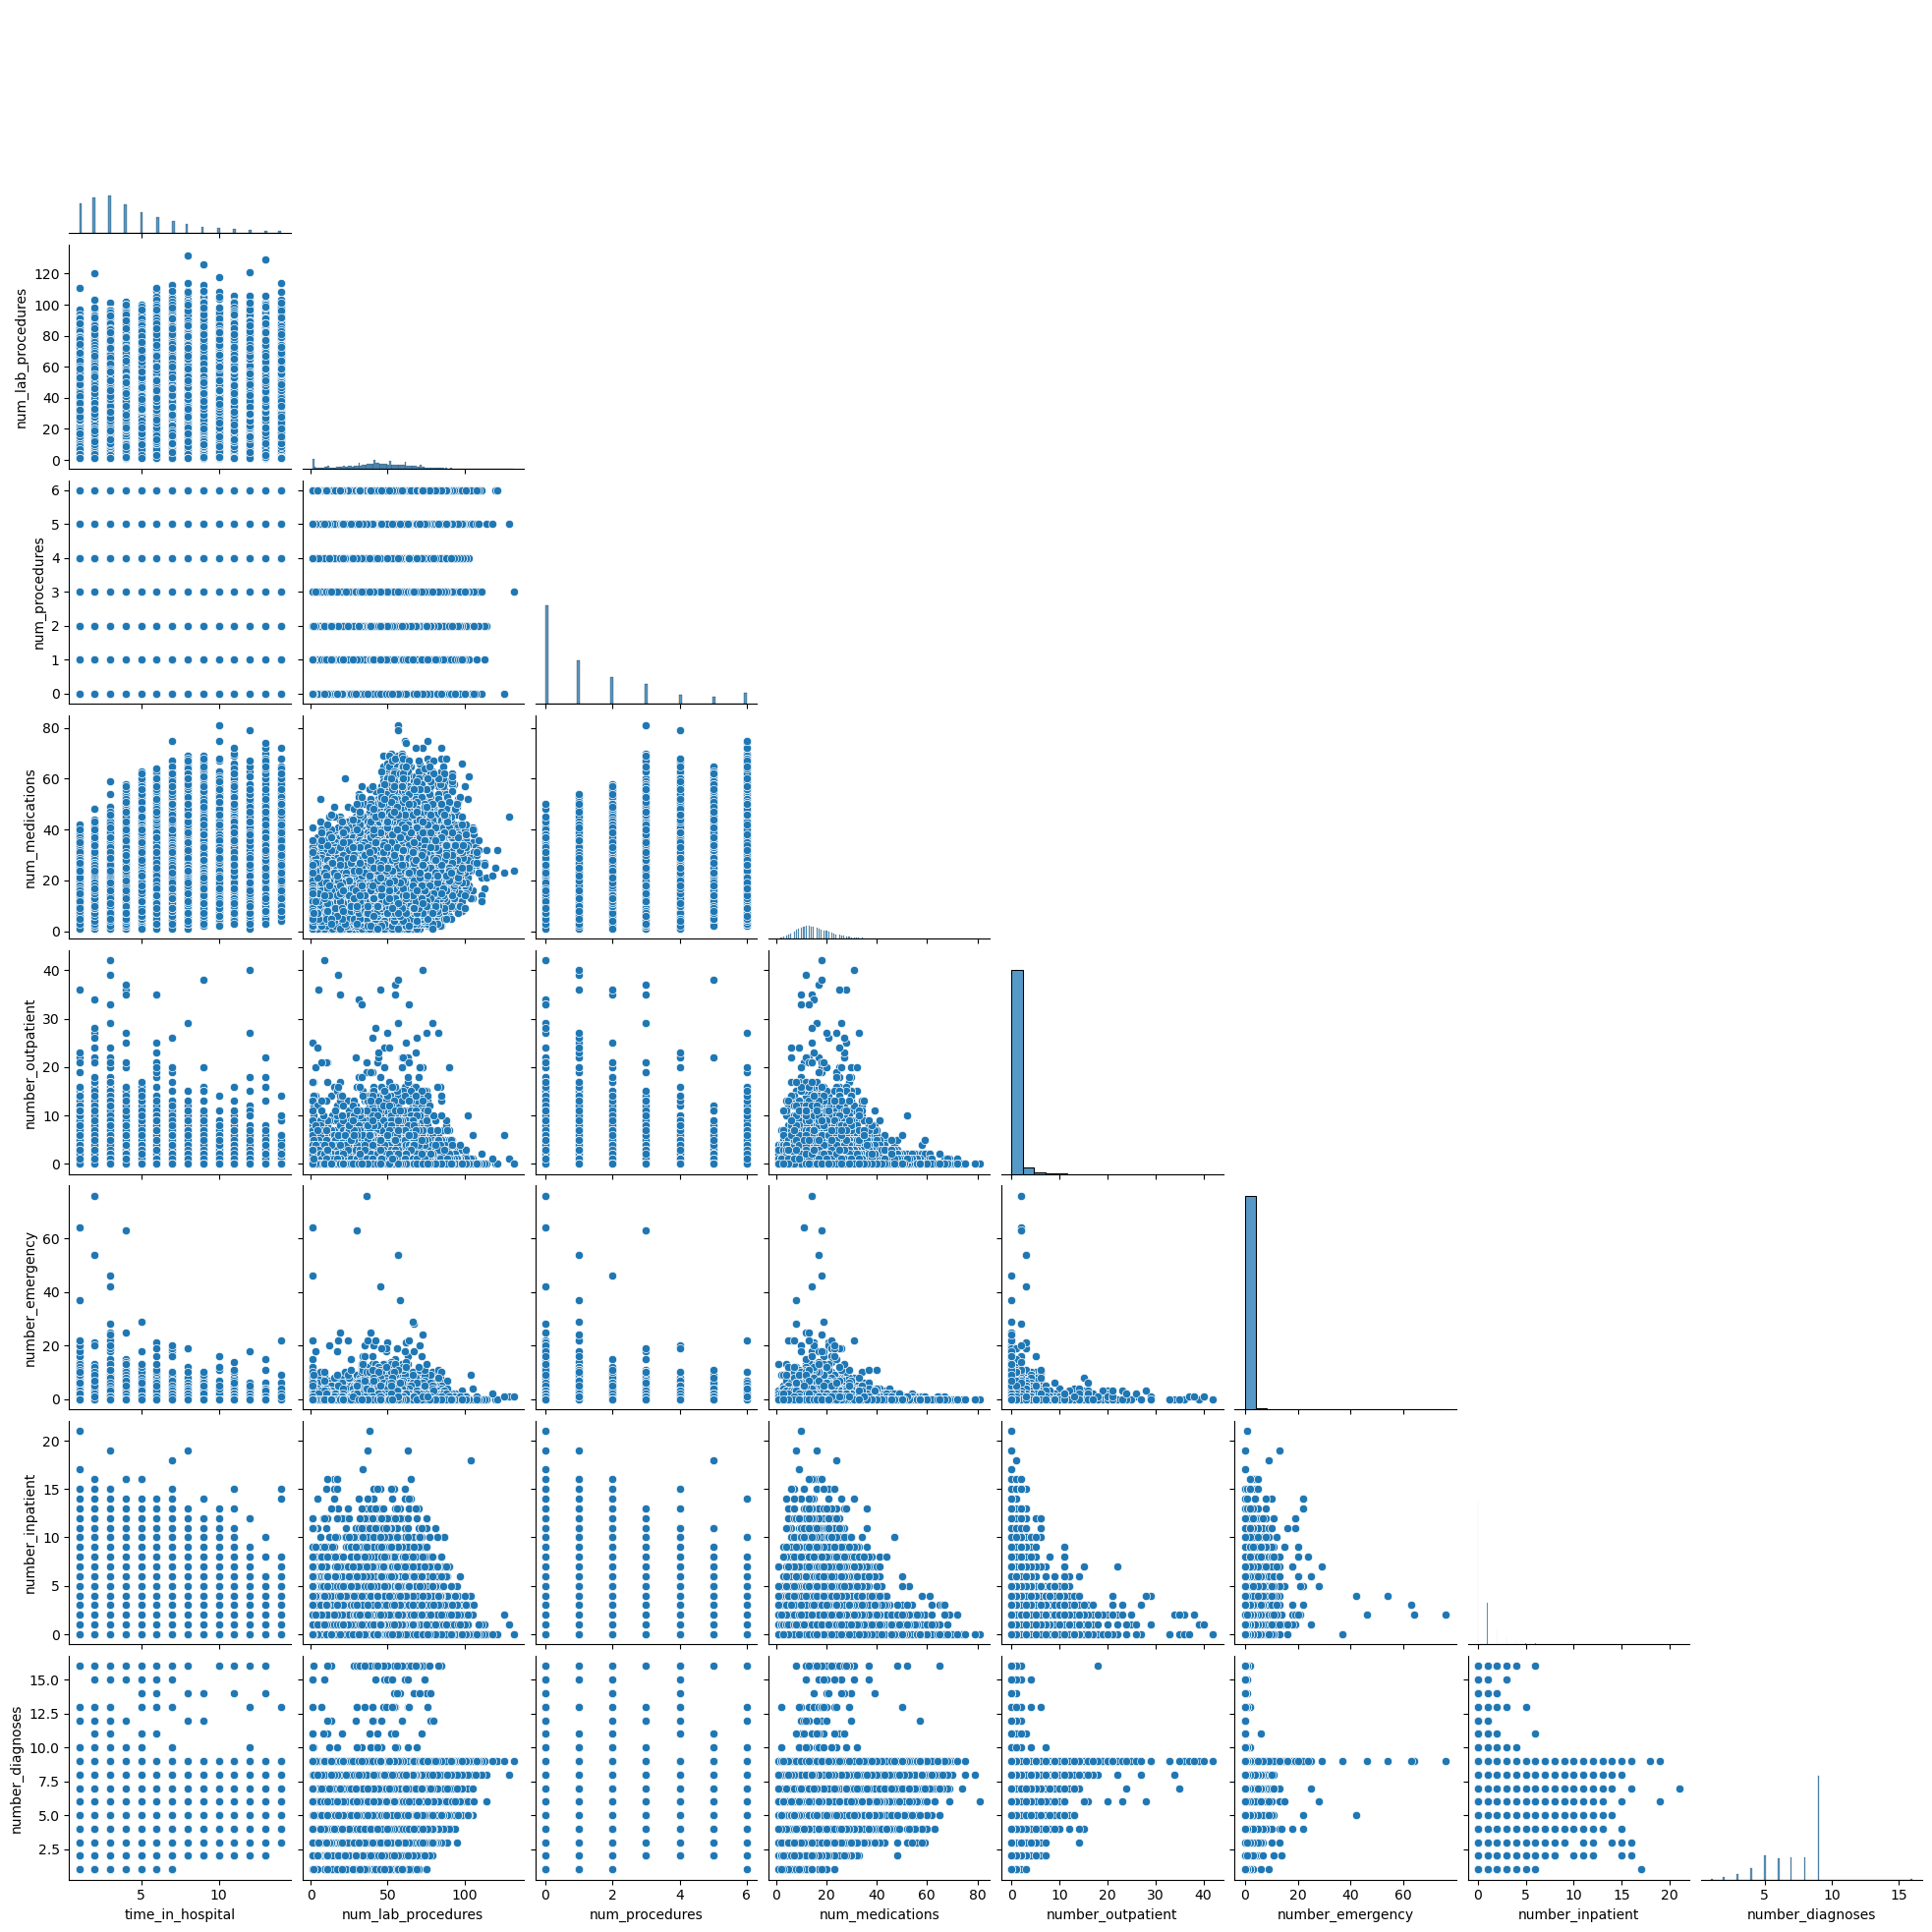

In [32]:
plt.rcParams["figure.figsize"] = (15, 10)
sns.pairplot(df[num_col].replace("?", np.nan), corner=True)
plt.savefig("../outputs/plots/pairplot.png")

For numerical columns, we can compute average, sum, max, min, or other aggregation values for each numerical feature after

* Grouping by unique patient number

* Grouping by medical specialty

* Grouping by demographic characteristics such as age, gender, race

### Categorical Features

In [18]:
# Identify columns with high cardinality
high_cardinality = []
for col in cat_col:
    if df[col].nunique() > 20:
        high_cardinality.append(col)
        print(f"Number of unique values in {col} is", df[col].nunique())

Number of unique values in discharge_disposition_id is 26
Number of unique values in medical_specialty is 73
Number of unique values in diag_1 is 717
Number of unique values in diag_2 is 749
Number of unique values in diag_3 is 790


In [19]:
for col in high_cardinality:
    print(f"Column {col} has missing values ?", any(df[col] == "?"))

Column discharge_disposition_id has missing values ? False
Column medical_specialty has missing values ? True
Column diag_1 has missing values ? True
Column diag_2 has missing values ? True
Column diag_3 has missing values ? True


Plots for all categorical variables with fewer than $20$ categories:

<AxesSubplot:title={'center':'repaglinide'}>

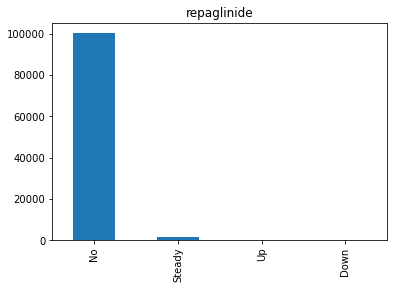

<AxesSubplot:title={'center':'metformin'}>

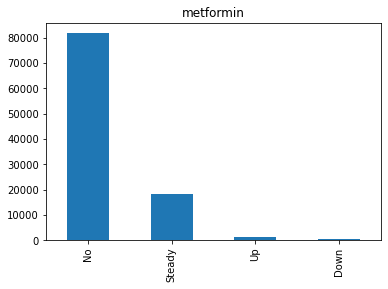

<AxesSubplot:title={'center':'troglitazone'}>

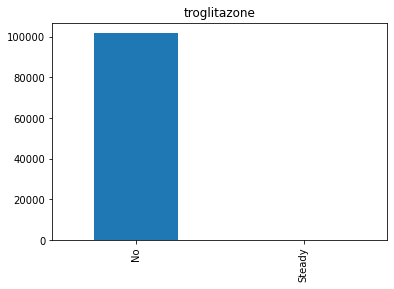

<AxesSubplot:title={'center':'acarbose'}>

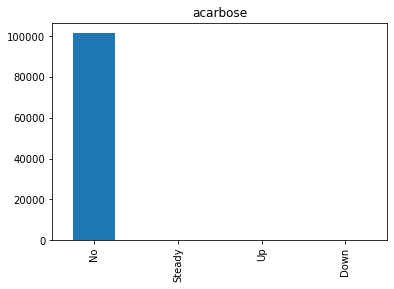

<AxesSubplot:title={'center':'A1Cresult'}>

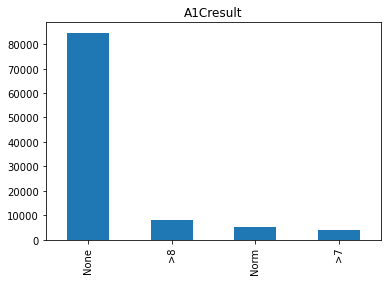

<AxesSubplot:title={'center':'glyburide-metformin'}>

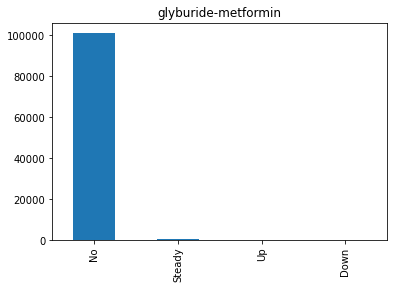

<AxesSubplot:title={'center':'max_glu_serum'}>

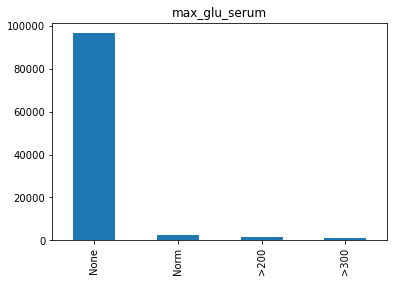

<AxesSubplot:title={'center':'change'}>

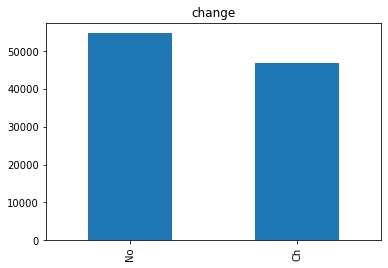

<AxesSubplot:title={'center':'glimepiride'}>

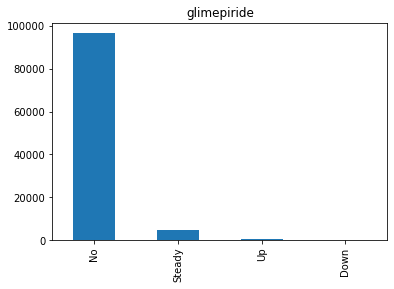

<AxesSubplot:title={'center':'nateglinide'}>

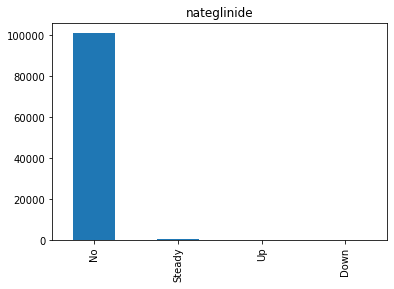

<AxesSubplot:title={'center':'tolazamide'}>

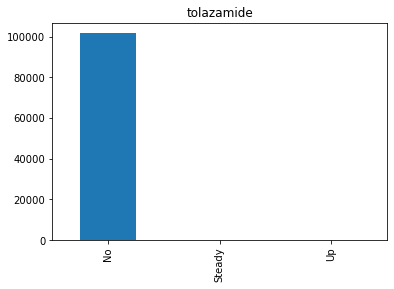

<AxesSubplot:title={'center':'payer_code'}>

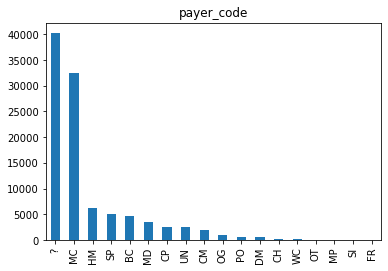

<AxesSubplot:title={'center':'pioglitazone'}>

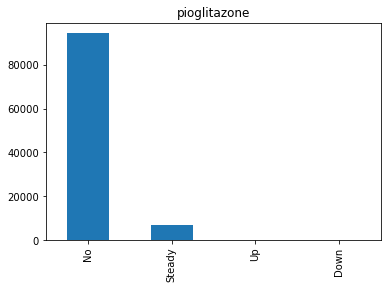

<AxesSubplot:title={'center':'insulin'}>

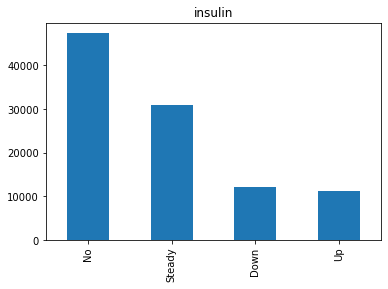

<AxesSubplot:title={'center':'metformin-pioglitazone'}>

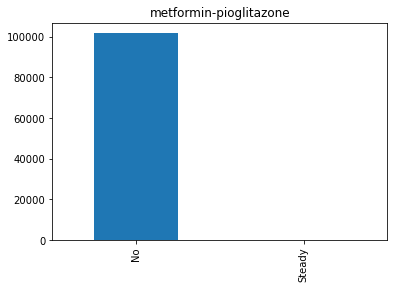

<AxesSubplot:title={'center':'admission_source_id'}>

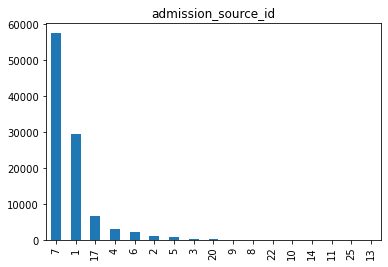

<AxesSubplot:title={'center':'admission_type_id'}>

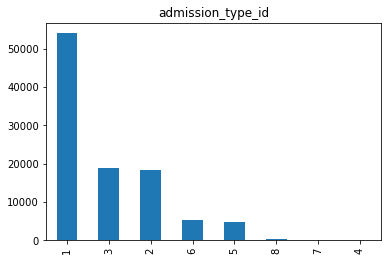

<AxesSubplot:title={'center':'examide'}>

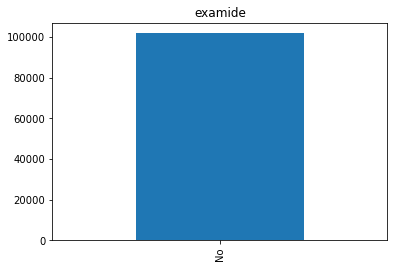

<AxesSubplot:title={'center':'gender'}>

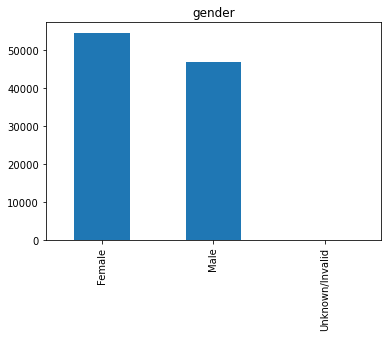

<AxesSubplot:title={'center':'age'}>

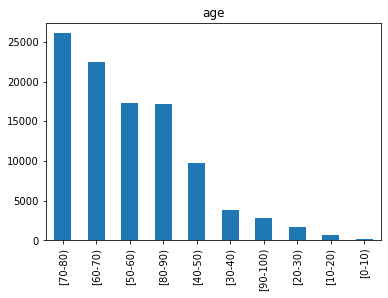

<AxesSubplot:title={'center':'citoglipton'}>

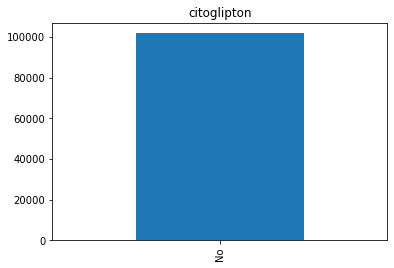

<AxesSubplot:title={'center':'glipizide-metformin'}>

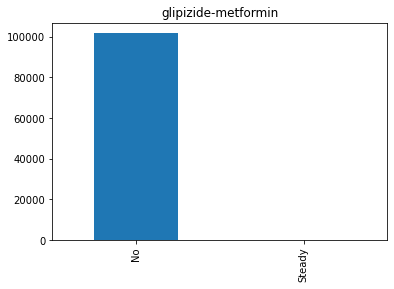

<AxesSubplot:title={'center':'glipizide'}>

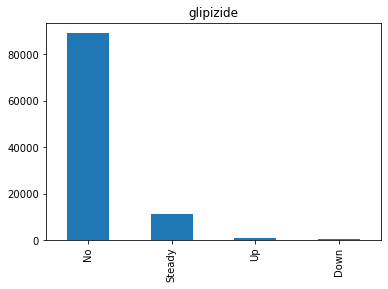

<AxesSubplot:title={'center':'glimepiride-pioglitazone'}>

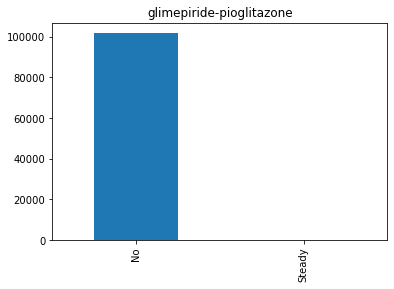

<AxesSubplot:title={'center':'chlorpropamide'}>

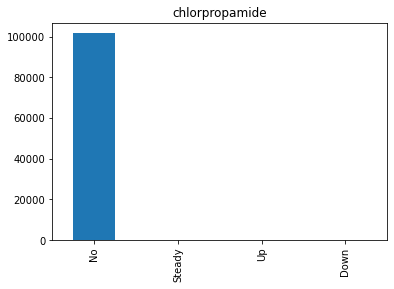

<AxesSubplot:title={'center':'glyburide'}>

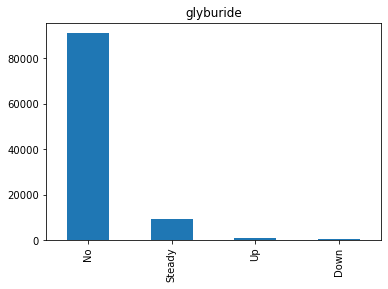

<AxesSubplot:title={'center':'diabetesMed'}>

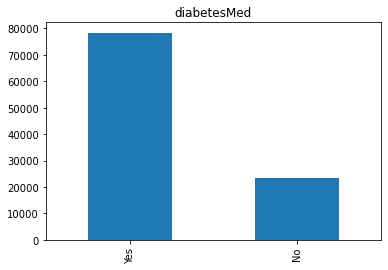

<AxesSubplot:title={'center':'race'}>

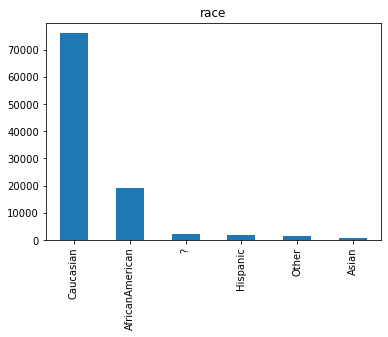

<AxesSubplot:title={'center':'miglitol'}>

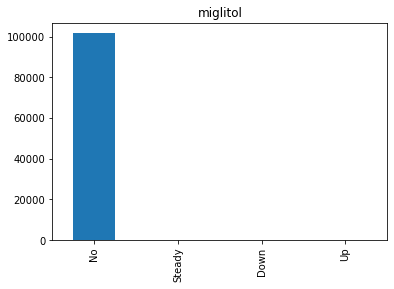

<AxesSubplot:title={'center':'acetohexamide'}>

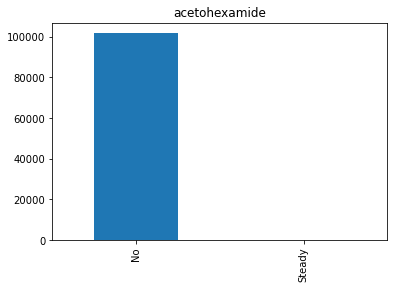

<AxesSubplot:title={'center':'tolbutamide'}>

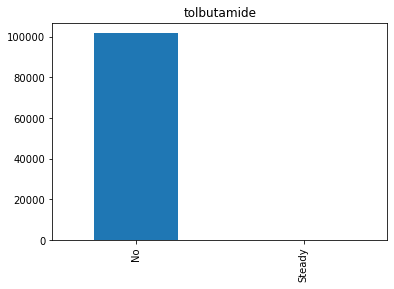

<AxesSubplot:title={'center':'metformin-rosiglitazone'}>

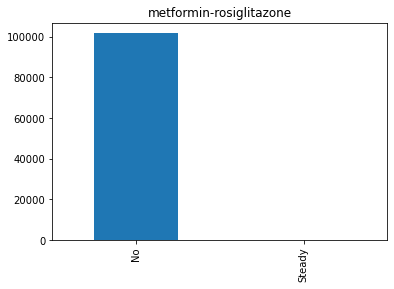

<AxesSubplot:title={'center':'rosiglitazone'}>

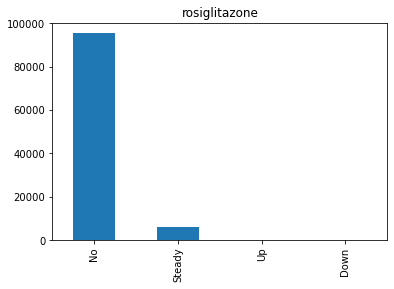

In [20]:
for col in list(set(cat_col) - set(high_cardinality)):
    df[col].value_counts(dropna=False).plot(kind="bar", title=col)
    plt.show()

* Features like `race`, `payer_code`, `medical_specialty`, `diag_1`, `diag_2`, and `diag_3` contain missing values. It may not be sensible to impute columns that are sensitive like race, medical specialty, and payer_code. The cost of getting those wrong can introduce biases to the algorithm. So we can simply keep the 'unknown' or '?' category.

* Features like `A1Cresult`, `max_glue_serum`, and others appear to be ordinal, so we could potentially use `OrdinalEncoder` for these features.

### Missing Ratios

In [21]:
# Obtain all columns that contain '?'
cols_with_missing = list(
    compress(df.columns, df.apply(lambda x: x.isin(["?"]).any(), axis=0))
)
cols_with_missing

['race',
 'weight',
 'payer_code',
 'medical_specialty',
 'diag_1',
 'diag_2',
 'diag_3']

<AxesSubplot:>

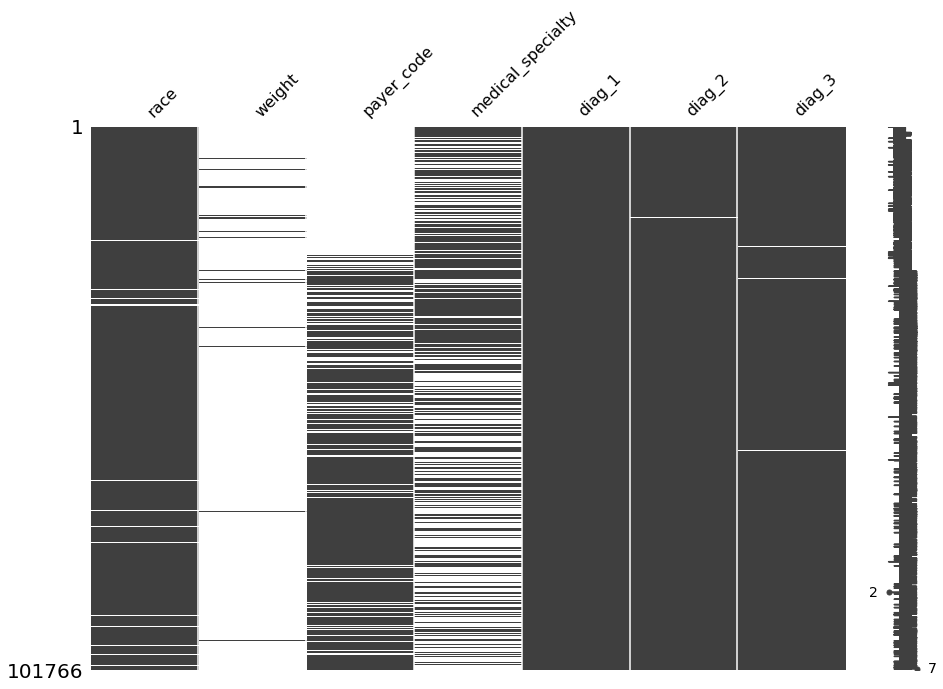

In [22]:
df_missing = df[cols_with_missing].copy(deep=True)
df_missing.replace("?", np.nan, inplace=True)
matrix(df_missing, figsize=(15, 10))
plt.savefig("../outputs/plots/eda_missing_matrix.png", facecolor="white")

<AxesSubplot:>

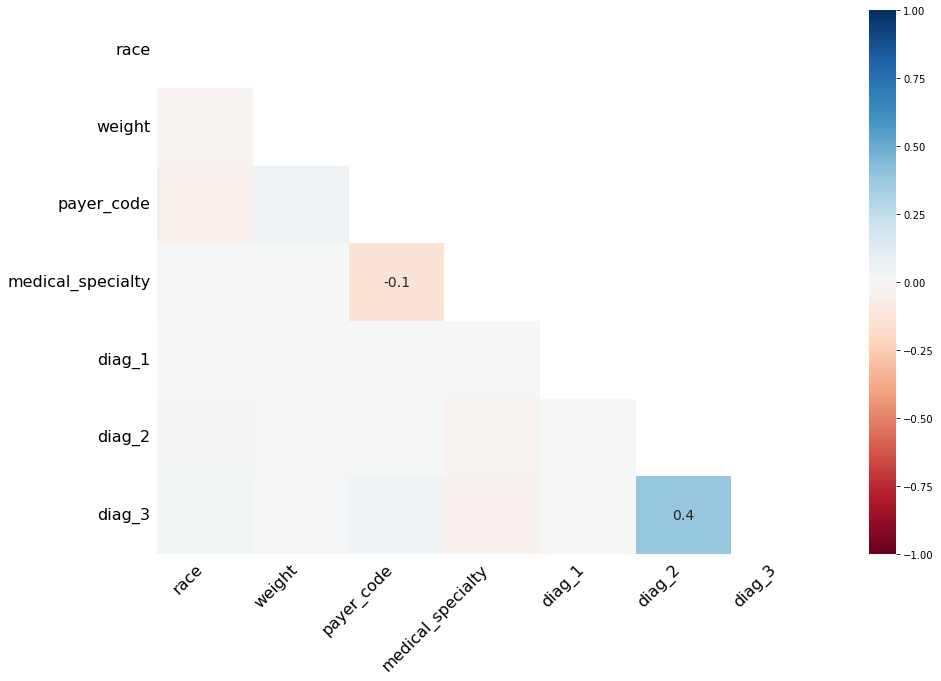

In [23]:
heatmap(df_missing, figsize=(15, 10))
plt.savefig("../outputs/plots/eda_missing_correlated.png", facecolor="white")
del df_missing

* Diagnosis 2 and 3 are positively correlated, so their simultaneously missing may also be correlated. 

## Preprocessor Pipeline

### Train Test Split

In [81]:
# Stratified train test split to keep imbalanced nature of the target
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=rs)

for train_index, test_index in sss.split(df, df[target]):
    df_train = df.iloc[train_index]
    df_test = df.iloc[test_index]

In [82]:
df_train[target].value_counts(dropna=False, normalize=True)

NO     0.539122
>30    0.349285
<30    0.111593
Name: readmitted, dtype: float64

In [83]:
df_test[target].value_counts(dropna=False, normalize=True)

NO     0.539108
>30    0.349268
<30    0.111624
Name: readmitted, dtype: float64

In [84]:
# Write to disk
df_train.drop(target, axis=1).to_parquet(
    "../data/train_test/train_X.parquet", index=False
)
pd.DataFrame(df_train[target]).to_parquet(
    "../data/train_test/train_y.parquet", index=False
)
df_test.drop(target, axis=1).to_parquet(
    "../data/train_test/test_X.parquet", index=False
)
pd.DataFrame(df_test[target]).to_parquet(
    "../data/train_test/test_y.parquet", index=False
)

### Pipeline

The Ordinal Encoder from sklearn returns a numpy array. The Ordinal Encoder from features_engine returns a DataFrame, which is convenient. But the sklearn implementation has the benefit of allowing us to specify the categories for each feature. In our case, the 23 features for medications should all have four levels--- 'No', 'Steady', 'Up', 'Down'--- even if some were not observed in the training data. The encoder 
should know how to encode those categories if they arise in test data or new data. This can only work if we
pre-specify the expected categories for those features using the sklearn implementation.

* Some categorical features can be encoded arbitrarily using `OrdinalEncoder` from `feature_engine`

* The medication features must handle all four levels using `OrdinalEncoder` from `sklearn`

Even if the two groups of categorical columns are handled separately; we handle categories that were not observed at `fit` time (missing in training data) by encoding them as -1 if they were to be encountered at `transform` time (when applying pipeline that has fitted to training data to new unseen data).  

In [85]:
# Columns that need pre-specified categories lists
med_cols = [
    "metformin",
    "repaglinide",
    "nateglinide",
    "chlorpropamide",
    "glimepiride",
    "acetohexamide",
    "glipizide",
    "glyburide",
    "tolbutamide",
    "pioglitazone",
    "rosiglitazone",
    "acarbose",
    "miglitol",
    "troglitazone",
    "tolazamide",
    "examide",
    "citoglipton",
    "insulin",
    "glyburide-metformin",
    "glipizide-metformin",
    "glimepiride-pioglitazone",
    "metformin-rosiglitazone",
    "metformin-pioglitazone",
]

In [86]:
# Columns that can be encoded arbitrarily
arbitrary_cat_cols = list(set(cat_col) - set(med_cols))

In [87]:
# We need a list of 23 lists, one for each medication feature
list_of_med_cat = list(repeat(["No", "Down", "Steady", "Up"], 23))

The first six pre-processing steps should significantly lower the memory foot print of the original data. Taking the training data with 48 features of ~$171.6646$ mb down to ~$9.4691$ mb.

In [88]:
preprocessor = Pipeline(
    [
        # Preprocessing for data type, categorical ending, and downcasting
        (
            "drop_weight",
            DropFeatures(features_to_drop=["weight"]),
        ),  # First step is to drop the weight column with severe of missingness
        (
            "dtype_transformer",
            FunctionTransformer(tfr.DtypeTransformer, kw_args={"copy": False}),
        ),  # DataType handling
        (
            "encode_categorical",
            fe.OrdinalEncoder(
                encoding_method="arbitrary",
                variables=arbitrary_cat_cols,
                unseen="encode",
            ),
        ),  # Encode unseen with -1
        (
            "encode_medication",
            ColumnTransformer(
                [
                    (
                        "med_encode",
                        OrdinalEncoder(
                            categories=list_of_med_cat,
                            dtype=np.int8,
                            handle_unknown="use_encoded_value",
                            unknown_value=-1,
                        ),
                        med_cols,
                    )
                ],
                remainder="passthrough",
            ),
        ),  # Passed through columns are appended to the end of the transformed columns
        (
            "restore_pd",
            FunctionTransformer(tfr.RestoreTransformer),
        ),  # Restore pandas DataFrame
        (
            "convert_cat",
            FunctionTransformer(tfr.CatTransformer),
        ),  # Convert categorical columns to category dtype
        # Preprocessing for numerical features
        (
            "num_engine",
            FunctionTransformer(tfr.NumTransformer),
        ),  # Numerical feature engineering
        ("drop_ids", DropFeatures(features_to_drop=["encounter_id", "patient_nbr"])),
    ]
)
label_encoder = LabelEncoder()

In [89]:
joblib.dump(preprocessor, "../outputs/pipeline/preprocessor.joblib")
joblib.dump(label_encoder, "../outputs/pipeline/label_encoder.joblib")

['../outputs/pipeline/preprocessor.joblib']

['../outputs/pipeline/label_encoder.joblib']

Before we move on to modeling with xgboost, we need to complete the pipeline with a feature selection algorithm.

## Feature Selection

The three candidates to try for this project:

* recursive feature elimination (backward) using a simple decision tree
* best subset (using mutual information to select the highest scoring features)

An important decision to make is how many features to keep.

In [90]:
# Clone the pipeline and fit it to the training data
preprocessor_copy = clone(preprocessor)
label_encoder_copy = clone(label_encoder)
# Fit the copied pipeline to the training data
train_X = preprocessor_copy.fit_transform(df_train.drop(target, axis=1))
train_y = label_encoder_copy.fit_transform(df_train[target])
train_X.shape, train_y.shape

((81412, 206), (81412,))

### PCA

Some PCA to investigate if the data matrix is intrinsically lower dimensional:

In [87]:
pca_df = StandardScaler().fit_transform(train_X)
pca = PCA(n_components=100).fit(pca_df)

Scree plot:

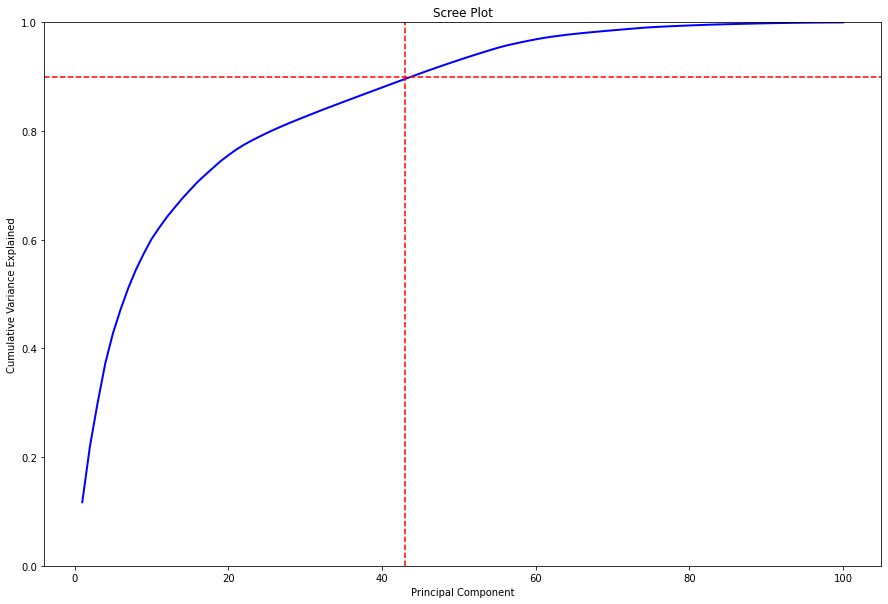

In [90]:
# Plot scree plot for pca
plt.plot(
    np.arange(pca.n_components_) + 1,
    np.cumsum(pca.explained_variance_ratio_),
    linewidth=2,
    color="blue",
)
plt.title("Scree Plot")
plt.xlabel("Principal Component")
plt.axvline(
    x=np.min(np.argwhere(np.cumsum(pca.explained_variance_ratio_) > 0.9)),
    color="red",
    linestyle="--",
)
plt.axhline(y=0.9, color="red", linestyle="--")
plt.ylim(0, 1.0)
plt.ylabel("Cumulative Variance Explained")
plt.show();

It only takes 45 principal components to explain over $90\%$ of variance:

In [91]:
np.min(np.argwhere(np.cumsum(pca.explained_variance_ratio_) > 0.9))

43

The first three PC's explain about $30\%$ of the variance:

In [92]:
perc = pd.DataFrame(
    {
        "pc": ["PC" + str(i) for i in range(1, 11)],
        "Cumulative Variance Explained": np.cumsum(pca.explained_variance_ratio_)[:10],
    }
)
perc

pc  Cumulative Variance Explained
0   PC1                       0.116884
1   PC2                       0.219694
2   PC3                       0.299718
3   PC4                       0.372543
4   PC5                       0.428006
5   PC6                       0.472081
6   PC7                       0.511317
7   PC8                       0.545174
8   PC9                       0.574150
9  PC10                       0.600725

In [93]:
df_train[target].to_numpy()

array(['NO', '<30', '>30', ..., 'NO', 'NO', '>30'], dtype=object)

In [95]:
pc = pd.DataFrame(
    pca.transform(pca_df)[:, :3], columns=["PC " + str(i) for i in range(1, 4)]
)
# Add label for plotting
pc["label"] = df_train[target].to_numpy()
pc

PC 1      PC 2      PC 3 label
0      5.666083 -0.770270 -1.310579    NO
1     -3.497132 -2.844779  3.082337   <30
2     -4.738062 -4.399885  0.519062   >30
3     -5.739685  5.116964  3.319506    NO
4     -4.628981 -3.578346  1.867609    NO
...         ...       ...       ...   ...
81407  5.114692 -0.881412  2.425887   >30
81408  5.576362 -0.482476 -0.926158   <30
81409  2.001972  8.339974 -7.136942    NO
81410 -2.569970 -3.982558 -2.272947    NO
81411 -5.709425  3.692209 -2.711513   >30

[81412 rows x 4 columns]

In [96]:
fig = px.scatter_3d(
    pc, x="PC 1", y="PC 2", z="PC 3", color="label", width=1000, height=500
)
fig.update_layout(
    margin=dict(l=15, r=15, t=20, b=20),
    paper_bgcolor="LightSteelBlue",
)
fig.write_html(
    "../outputs/plots/first_three_pc.html"
)  # Write interactive 3d plot to html file
fig.show();

### Recursive Feature Elimination

In [17]:
ref_selector = RFE(
    estimator=DecisionTreeClassifier(random_state=rs),
    n_features_to_select=50,
    step=0.1,
    verbose=2,
)

A quick five-fold cv to evaluate the performance of the model with the selected features, f1 score, and simple balanced accuracy score. In addition, we use a combination of SMOTE and edited nearest neighbors to address the imbalanced problem:

In [18]:
sm = SMOTE(
    sampling_strategy="auto",
    random_state=rs,
    k_neighbors=NearestNeighbors(n_neighbors=10, n_jobs=-1),
)
bl_sm = BorderlineSMOTE(
    sampling_strategy="auto",
    random_state=rs,
    k_neighbors=NearestNeighbors(n_neighbors=10, n_jobs=-1),
    kind="borderline-1",
)
ada_syn = ADASYN(
    sampling_strategy="auto",
    random_state=rs,
    n_neighbors=NearestNeighbors(n_neighbors=10, n_jobs=-1),
)

In [19]:
train_X, train_y = df_train, df_train.loc[:, target]

for fold, (train_idx, test_idx) in enumerate(
    StratifiedKFold(n_splits=5, random_state=rs, shuffle=True).split(train_X, train_y)
):
    # Split fold k
    fold_train_X, fold_train_y = train_X.iloc[train_idx, :], train_y.iloc[train_idx]
    fold_validate_X, fold_validate_y = train_X.iloc[test_idx, :], train_y.iloc[test_idx]

    # Preprocess
    preprocessor_copy = clone(preprocessor)
    label_encoder_copy = clone(label_encoder)
    # Fit the copied pipeline to the training data
    fold_train_X = preprocessor_copy.fit_transform(fold_train_X)
    fold_train_y = label_encoder_copy.fit_transform(fold_train_y.to_numpy())
    fold_validate_X = preprocessor_copy.transform(fold_validate_X)
    fold_validate_y = label_encoder_copy.transform(fold_validate_y.to_numpy())

    # Fit a fresh copy of the selector to the fold training data and transform the fold training data
    fresh_rfe_selector = clone(ref_selector)
    fold_train_X = fresh_rfe_selector.fit_transform(fold_train_X, fold_train_y)
    fold_validate_X = fresh_rfe_selector.transform(fold_validate_X)

    bl_sm_copy = clone(bl_sm)
    print(
        "Class distribution of fold train set before resampling:",
        np.unique(fold_train_y, return_counts=True),
    )
    # Resampling
    fold_train_X, fold_train_y = bl_sm_copy.fit_resample(fold_train_X, fold_train_y)
    print(
        "Class distribution of fold train set after resampling:",
        np.unique(fold_train_y, return_counts=True),
    )

    # Boosted tree model with mostly default parameters
    xgb_model = xgb.XGBClassifier(
        n_estimators=100, objective="multi:softmax", tree_method="hist", n_jobs=-1
    )
    print(f"Fitting model for fold {fold + 1} ...")
    xgb_model.fit(fold_train_X, fold_train_y)
    print(
        "Accuracy on training set:",
        balanced_accuracy_score(
            y_true=fold_train_y, y_pred=xgb_model.predict(fold_train_X)
        ),
    )
    print(
        "Accuracy on validation set:",
        balanced_accuracy_score(
            y_true=fold_validate_y, y_pred=xgb_model.predict(fold_validate_X)
        ),
    )
    print(
        "F-score on the training set:",
        f1_score(
            y_true=fold_train_y,
            y_pred=xgb_model.predict(fold_train_X),
            average="weighted",
        ),
    )
    print(
        "F-score on the validation set:",
        f1_score(
            y_true=fold_validate_y,
            y_pred=xgb_model.predict(fold_validate_X),
            average="weighted",
        ),
    )
    print("The class coding is:", label_encoder_copy.classes_)
    print(
        "Validation set report:\n",
        classification_report_imbalanced(
            y_true=fold_validate_y, y_pred=xgb_model.predict(fold_validate_X)
        ),
    )

Fitting estimator with 206 features.
Fitting estimator with 186 features.
Fitting estimator with 166 features.
Fitting estimator with 146 features.
Fitting estimator with 126 features.
Fitting estimator with 106 features.
Fitting estimator with 86 features.
Fitting estimator with 66 features.
Class distribution of fold train set before resampling: (array([0, 1, 2]), array([ 7268, 22749, 35112]))
Class distribution of fold train set after resampling: (array([0, 1, 2]), array([35112, 35112, 35112]))
Fitting model for fold 1 ...


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, objective='multi:softmax',
              predictor='auto', ...)

Accuracy on training set: 0.8024986709197236
Accuracy on validation set: 0.4431354117986183
F-score on the training set: 0.7983963976871752
F-score on the validation set: 0.5112927981075802
The class coding is: ['<30' '>30' 'NO']
Validation set report:
                    pre       rec       spe        f1       geo       iba       sup

          0       0.31      0.17      0.95      0.22      0.41      0.15      1817
          1       0.42      0.67      0.50      0.52      0.58      0.34      5687
          2       0.69      0.48      0.75      0.57      0.60      0.35      8779

avg / total       0.55      0.51      0.68      0.51      0.57      0.33     16283

Fitting estimator with 206 features.
Fitting estimator with 186 features.
Fitting estimator with 166 features.
Fitting estimator with 146 features.
Fitting estimator with 126 features.
Fitting estimator with 106 features.
Fitting estimator with 86 features.
Fitting estimator with 66 features.
Class distribution of fold train s

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, objective='multi:softmax',
              predictor='auto', ...)

Accuracy on training set: 0.7989728400687305
Accuracy on validation set: 0.4543420938034674
F-score on the training set: 0.7942347299230796
F-score on the validation set: 0.5488987693592221
The class coding is: ['<30' '>30' 'NO']
Validation set report:
                    pre       rec       spe        f1       geo       iba       sup

          0       0.32      0.16      0.96      0.22      0.40      0.14      1817
          1       0.45      0.59      0.61      0.51      0.60      0.36      5688
          2       0.68      0.61      0.66      0.64      0.64      0.40      8778

avg / total       0.56      0.55      0.68      0.55      0.60      0.36     16283

Fitting estimator with 206 features.
Fitting estimator with 186 features.
Fitting estimator with 166 features.
Fitting estimator with 146 features.
Fitting estimator with 126 features.
Fitting estimator with 106 features.
Fitting estimator with 86 features.
Fitting estimator with 66 features.
Class distribution of fold train s

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, objective='multi:softmax',
              predictor='auto', ...)

Accuracy on training set: 0.7988399358262371
Accuracy on validation set: 0.4263596262552359
F-score on the training set: 0.794183891089268
F-score on the validation set: 0.4547791074753591
The class coding is: ['<30' '>30' 'NO']
Validation set report:
                    pre       rec       spe        f1       geo       iba       sup

          0       0.32      0.15      0.96      0.21      0.39      0.14      1817
          1       0.40      0.79      0.35      0.53      0.53      0.29      5687
          2       0.73      0.34      0.85      0.46      0.53      0.27      8778

avg / total       0.57      0.47      0.69      0.45      0.52      0.26     16282

Fitting estimator with 206 features.
Fitting estimator with 186 features.
Fitting estimator with 166 features.
Fitting estimator with 146 features.
Fitting estimator with 126 features.
Fitting estimator with 106 features.
Fitting estimator with 86 features.
Fitting estimator with 66 features.
Class distribution of fold train se

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, objective='multi:softmax',
              predictor='auto', ...)

Accuracy on training set: 0.7995234433590598
Accuracy on validation set: 0.43555299842835793
F-score on the training set: 0.7949837105082622
F-score on the validation set: 0.5505860773825656
The class coding is: ['<30' '>30' 'NO']
Validation set report:
                    pre       rec       spe        f1       geo       iba       sup

          0       0.48      0.09      0.99      0.15      0.30      0.08      1817
          1       0.61      0.27      0.91      0.37      0.49      0.23      5687
          2       0.62      0.95      0.32      0.75      0.55      0.32      8778

avg / total       0.60      0.61      0.60      0.55      0.50      0.26     16282

Fitting estimator with 206 features.
Fitting estimator with 186 features.
Fitting estimator with 166 features.
Fitting estimator with 146 features.
Fitting estimator with 126 features.
Fitting estimator with 106 features.
Fitting estimator with 86 features.
Fitting estimator with 66 features.
Class distribution of fold train 

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, objective='multi:softmax',
              predictor='auto', ...)

Accuracy on training set: 0.8008714721043488
Accuracy on validation set: 0.4363525168613986
F-score on the training set: 0.7964129268099741
F-score on the validation set: 0.5254937430362033
The class coding is: ['<30' '>30' 'NO']
Validation set report:
                    pre       rec       spe        f1       geo       iba       sup

          0       0.32      0.15      0.96      0.20      0.37      0.13      1817
          1       0.43      0.60      0.57      0.50      0.58      0.34      5687
          2       0.66      0.57      0.66      0.61      0.61      0.37      8778

avg / total       0.54      0.53      0.66      0.53      0.58      0.33     16282



### Best Subset Based on Mutual Information

In [20]:
best_sub = SelectKBest(score_func=mutual_info_classif, k=50)

In [21]:
train_X, train_y = df_train, df_train.loc[:, target]

for fold, (train_idx, test_idx) in enumerate(
    StratifiedKFold(n_splits=5, random_state=rs, shuffle=True).split(train_X, train_y)
):
    # Split fold k
    fold_train_X, fold_train_y = train_X.iloc[train_idx, :], train_y.iloc[train_idx]
    fold_validate_X, fold_validate_y = train_X.iloc[test_idx, :], train_y.iloc[test_idx]

    # Preprocess
    preprocessor_copy = clone(preprocessor)
    label_encoder_copy = clone(label_encoder)
    # Fit the copied pipeline to the training data
    fold_train_X = preprocessor_copy.fit_transform(fold_train_X)
    fold_train_y = label_encoder_copy.fit_transform(fold_train_y.to_numpy())
    fold_validate_X = preprocessor_copy.transform(fold_validate_X)
    fold_validate_y = label_encoder_copy.transform(fold_validate_y.to_numpy())

    # Fit a fresh copy of the selector to the fold training data and transform the fold training data
    fresh_best_sub_selector = clone(best_sub)
    fold_train_X = fresh_best_sub_selector.fit_transform(fold_train_X, fold_train_y)
    fold_validate_X = fresh_best_sub_selector.transform(fold_validate_X)

    bl_sm_copy = clone(bl_sm)
    print(
        "Class distribution of fold train set before resampling:",
        np.unique(fold_train_y, return_counts=True),
    )
    # Resampling
    fold_train_X, fold_train_y = bl_sm_copy.fit_resample(fold_train_X, fold_train_y)
    print(
        "Class distribution of fold train set after resampling:",
        np.unique(fold_train_y, return_counts=True),
    )

    # Boosted tree model with mostly default parameters
    xgb_model = xgb.XGBClassifier(
        n_estimators=100, objective="multi:softmax", tree_method="hist", n_jobs=-1
    )
    print(f"Fitting model for fold {fold + 1} ...")
    xgb_model.fit(fold_train_X, fold_train_y)
    print(
        "Accuracy on training set:",
        balanced_accuracy_score(
            y_true=fold_train_y, y_pred=xgb_model.predict(fold_train_X)
        ),
    )
    print(
        "Accuracy on validation set:",
        balanced_accuracy_score(
            y_true=fold_validate_y, y_pred=xgb_model.predict(fold_validate_X)
        ),
    )
    print(
        "F-score on the training set:",
        f1_score(
            y_true=fold_train_y,
            y_pred=xgb_model.predict(fold_train_X),
            average="weighted",
        ),
    )
    print(
        "F-score on the validation set:",
        f1_score(
            y_true=fold_validate_y,
            y_pred=xgb_model.predict(fold_validate_X),
            average="weighted",
        ),
    )
    print("The class coding is:", label_encoder_copy.classes_)
    print(
        "Validation set report:\n",
        classification_report_imbalanced(
            y_true=fold_validate_y, y_pred=xgb_model.predict(fold_validate_X)
        ),
    )

Class distribution of fold train set before resampling: (array([0, 1, 2]), array([ 7268, 22749, 35112]))
Class distribution of fold train set after resampling: (array([0, 1, 2]), array([35112, 35112, 35112]))
Fitting model for fold 1 ...


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, objective='multi:softmax',
              predictor='auto', ...)

Accuracy on training set: 0.7858471937419305
Accuracy on validation set: 0.4305641672481631
F-score on the training set: 0.7804880153006024
F-score on the validation set: 0.5469764129676701
The class coding is: ['<30' '>30' 'NO']
Validation set report:
                    pre       rec       spe        f1       geo       iba       sup

          0       0.41      0.08      0.99      0.14      0.29      0.07      1817
          1       0.60      0.27      0.90      0.37      0.49      0.23      5687
          2       0.62      0.94      0.32      0.74      0.55      0.32      8779

avg / total       0.59      0.61      0.60      0.55      0.50      0.26     16283

Class distribution of fold train set before resampling: (array([0, 1, 2]), array([ 7268, 22748, 35113]))
Class distribution of fold train set after resampling: (array([0, 1, 2]), array([35113, 35113, 35113]))
Fitting model for fold 2 ...


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, objective='multi:softmax',
              predictor='auto', ...)

Accuracy on training set: 0.7877329384178701
Accuracy on validation set: 0.4325932295981249
F-score on the training set: 0.7824313113282414
F-score on the validation set: 0.548195129974579
The class coding is: ['<30' '>30' 'NO']
Validation set report:
                    pre       rec       spe        f1       geo       iba       sup

          0       0.39      0.09      0.98      0.15      0.30      0.08      1817
          1       0.59      0.27      0.90      0.37      0.50      0.23      5688
          2       0.62      0.93      0.33      0.74      0.55      0.32      8778

avg / total       0.58      0.61      0.60      0.55      0.50      0.26     16283

Class distribution of fold train set before resampling: (array([0, 1, 2]), array([ 7268, 22749, 35113]))
Class distribution of fold train set after resampling: (array([0, 1, 2]), array([35113, 35113, 35113]))
Fitting model for fold 3 ...


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, objective='multi:softmax',
              predictor='auto', ...)

Accuracy on training set: 0.7830243309695364
Accuracy on validation set: 0.4297903675136334
F-score on the training set: 0.7769433780581337
F-score on the validation set: 0.5453789497209524
The class coding is: ['<30' '>30' 'NO']
Validation set report:
                    pre       rec       spe        f1       geo       iba       sup

          0       0.44      0.08      0.99      0.14      0.29      0.08      1817
          1       0.59      0.27      0.90      0.37      0.49      0.23      5687
          2       0.62      0.94      0.32      0.74      0.54      0.31      8778

avg / total       0.59      0.61      0.59      0.55      0.50      0.26     16282

Class distribution of fold train set before resampling: (array([0, 1, 2]), array([ 7268, 22749, 35113]))
Class distribution of fold train set after resampling: (array([0, 1, 2]), array([35113, 35113, 35113]))
Fitting model for fold 4 ...


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, objective='multi:softmax',
              predictor='auto', ...)

Accuracy on training set: 0.7880367195435688
Accuracy on validation set: 0.43014617248092973
F-score on the training set: 0.782434810533407
F-score on the validation set: 0.5473446843501805
The class coding is: ['<30' '>30' 'NO']
Validation set report:
                    pre       rec       spe        f1       geo       iba       sup

          0       0.42      0.08      0.99      0.13      0.28      0.07      1817
          1       0.60      0.27      0.90      0.38      0.50      0.23      5687
          2       0.62      0.94      0.32      0.74      0.55      0.32      8778

avg / total       0.59      0.61      0.60      0.55      0.50      0.26     16282

Class distribution of fold train set before resampling: (array([0, 1, 2]), array([ 7268, 22749, 35113]))
Class distribution of fold train set after resampling: (array([0, 1, 2]), array([35113, 35113, 35113]))
Fitting model for fold 5 ...


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, objective='multi:softmax',
              predictor='auto', ...)

Accuracy on training set: 0.786195046469019
Accuracy on validation set: 0.4209133121059972
F-score on the training set: 0.7803612611917998
F-score on the validation set: 0.5336069207701728
The class coding is: ['<30' '>30' 'NO']
Validation set report:
                    pre       rec       spe        f1       geo       iba       sup

          0       0.42      0.07      0.99      0.12      0.27      0.06      1817
          1       0.61      0.24      0.92      0.34      0.47      0.20      5687
          2       0.61      0.95      0.28      0.74      0.52      0.29      8778

avg / total       0.59      0.61      0.58      0.53      0.47      0.23     16282



### Compare Feature Selection

In [39]:
feat_select_comp = pd.DataFrame(
    {
        "bestk": fresh_best_sub_selector.get_feature_names_out(),
        "rfe": fresh_rfe_selector.get_feature_names_out(),
    }
)
feat_select_comp

bestk  \
0                              number_emergency   
1                              number_inpatient   
2                      discharge_disposition_id   
3                                        diag_1   
4                                        diag_2   
5                                        diag_3   
6             time_in_hospital_median_by_gender   
7                  num_procedures_max_by_gender   
8                number_diagnoses_max_by_gender   
9               time_in_hospital_median_by_race   
10            num_lab_procedures_median_by_race   
11                 number_inpatient_sum_by_race   
12          num_medications_mean_by_patient_nbr   
13           num_procedures_mean_by_patient_nbr   
14         time_in_hospital_mean_by_patient_nbr   
15         number_emergency_mean_by_patient_nbr   
16         number_inpatient_mean_by_patient_nbr   
17        number_outpatient_mean_by_patient_nbr   
18       num_lab_procedures_mean_by_patient_nbr   
19         number_diagnoses_mean_by_patient_nbr   
20        num_medications_median_by_patient_nbr   
21         num_procedures_median_by_patient_nbr   
22       time_in_hospital_median_by_patient_nbr   
23       number_emergency_median_by_patient_nbr   
24       number_inpatient_median_by_patient_nbr   
25      number_outpatient_median_by_patient_nbr   
26     num_lab_procedures_median_by_patient_nbr   
27       number_diagnoses_median_by_patient_nbr   
28           num_medications_max_by_patient_nbr   
29          time_in_hospital_max_by_patient_nbr   
30          number_emergency_max_by_patient_nbr   
31          number_inpatient_max_by_patient_nbr   
32         number_outpatient_max_by_patient_nbr   
33        num_lab_procedures_max_by_patient_nbr   
34          number_diagnoses_max_by_patient_nbr   
35           num_medications_sum_by_patient_nbr   
36            num_procedures_sum_by_patient_nbr   
37          time_in_hospital_sum_by_patient_nbr   
38          number_emergency_sum_by_patient_nbr   
39          number_inpatient_sum_by_patient_nbr   
40         number_outpatient_sum_by_patient_nbr   
41        num_lab_procedures_sum_by_patient_nbr   
42          number_diagnoses_sum_by_patient_nbr   
43   time_in_hospital_mean_by_medical_specialty   
44  number_outpatient_mean_by_medical_specialty   
45      num_procedures_max_by_medical_specialty   
46     num_medications_sum_by_medical_specialty   
47      num_procedures_sum_by_medical_specialty   
48    time_in_hospital_sum_by_medical_specialty   
49    number_diagnoses_sum_by_medical_specialty   

                                             rfe  
0                                      metformin  
1                                      glipizide  
2                                        insulin  
3                               time_in_hospital  
4                             num_lab_procedures  
5                                 num_procedures  
6                                num_medications  
7                               number_inpatient  
8                               number_diagnoses  
9                                            age  
10                             admission_type_id  
11                      discharge_disposition_id  
12                           admission_source_id  
13                                    payer_code  
14                                        diag_1  
15                                        diag_2  
16                                        diag_3  
17                                     A1Cresult  
18                  time_in_hospital_mean_by_age  
19                  number_emergency_mean_by_age  
20                   number_emergency_max_by_age  
21                  number_outpatient_max_by_age  
22                   time_in_hospital_sum_by_age  
23                 number_emergency_mean_by_race  
24                num_lab_procedures_max_by_race  
25           num_medications_mean_by_patient_nbr  
26            num_procedures_mean_by_patient_nbr  
27          

Ultimately, the two feature selection techniques appear to be selecting similar features. Therefore, we will choose the recursive feature elimination algorithm as the final step of our pipeline.

# 
